In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#my function to check intersections and differences between sets of items
def check_sets(df1, col1, df2, col2, name1='first', name2='second'):
    set1 = set(df1[col1].unique())
    set2 = set(df2[col2].unique())
    print('in both files:', len(set1 & set2))
    print(f'in {name1} but not in {name2}:', len(set1 - set2))
    print(f'in {name2} but not in {name1}:', len(set2 - set1))

In [3]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales.shape

(883015, 8)

In [5]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [6]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [7]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [8]:
#estimate negative sales
minus_sales = sales[(sales['pr_sales_in_rub'] < 0) | (sales['pr_sales_in_units'] < 0) | (sales['pr_promo_sales_in_rub'] < 0) |(sales['pr_promo_sales_in_units'] < 0)]
minus_sales.shape

(70, 8)

In [9]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [10]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [11]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 5)

In [12]:
#detect top50 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
...                                                              ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...            5469.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...            5417.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...            5399.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...            5364.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...            5337.0   192   

                                                   pr_sales_in_rub        \
                                                               sum count   
store_item                                                                 
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        879274.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...       1999391.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...       1070819.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...       4187731.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        963222.0   352   
...                                                            ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        324306.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...         84293.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        643395.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        328648.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        913631.0   192   

                                                   all_sales_share  
                                                                    
store_item                                                          
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        0.168569  
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...        0.383311  
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...        0.205291  
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...        0.802847  
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        0.184663  
...                                                            ...  
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        0.062174  
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...        0.016160  
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        0.123348  
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        0.063006  
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        0.175156  

[150 rows x 5 columns]

In [13]:
#get top50 and check if there is data we're going to drop in those lines
top150 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150).reset_index()
zero_nonzero_sales['store_item'] = zero_nonzero_sales['st_id'].str.cat(zero_nonzero_sales['pr_sku_id'], sep='-')
check_sets(zero_nonzero_sales, 'store_item', top150.reset_index(), 'store_item', 'problem_data', 'top150')

in both files: 44
in problem_data but not in top150: 2907
in top150 but not in problem_data: 106


In [14]:
by_pair = by_pair.reset_index()

In [15]:
#separate top 150
no_top150 = by_pair[~by_pair['store_item'].isin(top150['store_item'])]
no_top150.shape

(5980, 6)

In [16]:
#find those pairs whose 80+ % of time series are non-zero. join with top 150
most_frequent = no_top150[no_top150[('pr_sales_in_units', 'count')] >= 352*0.8]
flagman = pd.concat([top150, most_frequent])
flagman.shape

(857, 6)

In [17]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0


In [18]:
#make train dataset out of top50 and their sales
train = oneline[oneline['store_item'].isin(flagman['store_item'])]
train.shape

(274130, 7)

In [19]:
train = train[['store_item', 'date', 'pr_sales_in_units']]
train.head()

,store_item,date,pr_sales_in_units
45,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-01,1.0
46,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-02,1.0
47,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-03,1.0
48,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-12,1.0
49,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-13,1.0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274130 entries, 45 to 660757
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   store_item         274130 non-null  object 
 1   date               274130 non-null  object 
 2   pr_sales_in_units  274130 non-null  float64
dtypes: float64(1), object(2)
memory usage: 8.4+ MB


In [21]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [22]:
train['date'].describe()

count                           274130
mean     2023-01-24 10:26:20.990041344
min                2022-08-01 00:00:00
25%                2022-10-28 00:00:00
50%                2023-01-25 00:00:00
75%                2023-04-23 00:00:00
max                2023-07-18 00:00:00
Name: date, dtype: object

In [23]:
#insert zeros for missing dates
train = train.sort_values(by='date')
train_pivoted = train.pivot(index='store_item', columns='date', values='pr_sales_in_units').fillna(0)

train_long = train_pivoted.stack().reset_index()
train_long = train_long.rename(columns={'level_1': 'date', 0: 'sold'})
train_long.head()

,store_item,date,sold
0,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-01,1.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-02,1.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-03,1.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-04,0.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-05,0.0


In [24]:
#assert number of lines equals 50 item-stores * 352 days
train_long.shape, 857*352

((301664, 3), 301664)

In [25]:
#another way to assert the above
assert train_long.groupby('store_item').size().describe()['std'] == 0

In [26]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [27]:
#add lag columns
shifted = train_long.set_index(['store_item', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="store_item").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

sold  \
store_item                                         date               
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01   1.0   
                                                   2022-08-02   1.0   
                                                   2022-08-03   1.0   
                                                   2022-08-04   0.0   
                                                   2022-08-05   0.0   

                                                               sold_lag_1  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         1.0   
                                                   2022-08-03         1.0   
                                                   2022-08-04         1.0   
                                                   2022-08-05         0.0   

                                                               sold_lag_2  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         1.0   
                                                   2022-08-04         1.0   
                                                   2022-08-05         1.0   

                                                               sold_lag_3  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         1.0   
                                                   2022-08-05         1.0   

                                                               sold_lag_4  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         1.0   

                                                               sold_lag_5  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         NaN   

                                                               sold_lag_6  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         NaN   

                                                               sold_lag_7  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                 

In [28]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(283667, 22)

In [29]:
#look at the edge between units to make sure lags don't mix up
new[328:334]

sold  \
store_item                                         date               
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16   0.0   
                                                   2023-07-17   2.0   
                                                   2023-07-18   1.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22   5.0   
                                                   2022-08-23   7.0   
                                                   2022-08-24   4.0   

                                                               sold_lag_1  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         4.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         2.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22         6.0   
                                                   2022-08-23         5.0   
                                                   2022-08-24         7.0   

                                                               sold_lag_2  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         0.0   
                                                   2023-07-17         4.0   
                                                   2023-07-18         0.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22        28.0   
                                                   2022-08-23         6.0   
                                                   2022-08-24         5.0   

                                                               sold_lag_3  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         2.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         4.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22        22.0   
                                                   2022-08-23        28.0   
                                                   2022-08-24         6.0   

                                                               sold_lag_4  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         2.0   
                                                   2023-07-17         2.0   
                                                   2023-07-18         0.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22         3.0   
                                                   2022-08-23        22.0   
                                                   2022-08-24        28.0   

                                                               sold_lag_5  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         4.0   
                                                   2023-07-17         2.0   
                                                   2023-07-18         2.0   
16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae50... 2022-08-22         7.0   
                                                   2022-08-23         3.0   
                                                   2022-08-24        22.0   

                                                               sold_lag_6  \
store_item                                         date                     
16a5cdae362b8d27a1d8f8c7b78b4330-00661699f54375... 2023-07-16         2.0   
                                                   2023-07-17         4.0   
                                                   2023-07-18         2.0   
16a5cdae362b8d27a1d8f8c7

In [30]:
new = new.reset_index()
new['date']

0        2022-08-22
1        2022-08-23
2        2022-08-24
3        2022-08-25
4        2022-08-26
            ...    
283662   2023-07-14
283663   2023-07-15
283664   2023-07-16
283665   2023-07-17
283666   2023-07-18
Name: date, Length: 283667, dtype: datetime64[ns]

In [31]:
#add promo flag
promo = oneline[oneline['store_item'].isin(top150.reset_index()['store_item'])][['store_item', 'date', 'pr_sales_type_id']]
promo['date'] = pd.to_datetime(promo['date']).dt.normalize()
with_promo = new.merge(promo, how='left', on=['store_item', 'date'])
with_promo.shape

(283667, 25)

In [32]:
with_promo.fillna(0, inplace=True)
with_promo.isna().sum()

store_item          0
date                0
sold                0
sold_lag_1          0
sold_lag_2          0
sold_lag_3          0
sold_lag_4          0
sold_lag_5          0
sold_lag_6          0
sold_lag_7          0
sold_lag_8          0
sold_lag_9          0
sold_lag_10         0
sold_lag_11         0
sold_lag_12         0
sold_lag_13         0
sold_lag_14         0
sold_lag_15         0
sold_lag_16         0
sold_lag_17         0
sold_lag_18         0
sold_lag_19         0
sold_lag_20         0
sold_lag_21         0
pr_sales_type_id    0
dtype: int64

In [33]:
#add features of day-of-week, day-of-month, week, month, season
with_promo['dow'] = with_promo['date'].dt.dayofweek
with_promo['day'] = with_promo['date'].dt.day
with_promo['week'] = with_promo['date'].dt.isocalendar().week.astype('int32')
with_promo['month'] = with_promo['date'].dt.month
with_promo['season'] = with_promo['date'].dt.quarter

In [34]:
#add separate features of item and store id
items_stores = sales[['store_item', 'st_id', 'pr_sku_id']].drop_duplicates(subset='store_item')
with_items_stores = with_promo.merge(items_stores, how='left', on='store_item')
with_items_stores.shape

(283667, 32)

In [35]:
#add more info on store
stores = pd.read_csv('st_df.csv')
stores.head()

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


In [36]:
stores.columns

Index(['st_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'st_is_active'],
      dtype='object')

In [37]:
with_stores = with_items_stores.merge(stores[['st_id', 
                                              'st_city_id', 
                                              'st_division_code', 
                                              'st_type_format_id',
                                              'st_type_loc_id', 
                                              'st_type_size_id']], how='left', on='st_id')
with_stores.shape

(283667, 37)

In [38]:
#add item classification
items = pd.read_csv('pr_df.csv')
items.head()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [39]:
items.columns

Index(['pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id'], dtype='object')

In [40]:
with_items = with_items_stores.merge(items[['pr_sku_id', 
                                            'pr_group_id', 
                                            'pr_cat_id', 
                                            'pr_subcat_id', 
                                            'pr_uom_id']], how='left', on='pr_sku_id')
with_items.shape

(283667, 36)

In [41]:
#let's try to calculate prices
prices = sales.groupby(['pr_sku_id', 'date', 'pr_sales_type_id'])[['pr_sales_in_units', 'pr_sales_in_rub']].sum()
prices = prices.sort_values(by=['pr_sku_id', 'date'])
prices = prices.reset_index()
prices['avg_daily_price'] = prices['pr_sales_in_rub'] / prices['pr_sales_in_units']
prices['avg_daily_price'].describe()

count    390861.000000
mean        142.830733
std         133.485941
min           0.500000
25%          52.000000
50%         116.333333
75%         190.500000
max        4729.000000
Name: avg_daily_price, dtype: float64

In [42]:
prices[prices['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a'].head()

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,avg_daily_price
151986,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,0,295.0,4249.0,14.403390
151987,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,1,31.0,411.0,13.258065
151988,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,0,289.0,4167.0,14.418685
151989,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,1,30.0,401.0,13.366667
151990,62d4af457ba2540ce0898a211c0cd17a,2022-08-03,0,351.0,5089.0,14.498575


In [43]:
discounts = prices.copy()
discounts = discounts.groupby(['pr_sku_id', 'date'])['avg_daily_price'].transform(lambda x: 1 - (x / x.max()))

In [44]:
discounts.name = 'discount'
prices_disc = prices.join(discounts)
prices_disc[prices_disc['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a'].head()

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,avg_daily_price,discount
151986,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,0,295.0,4249.0,14.403390,0.000000
151987,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,1,31.0,411.0,13.258065,0.079518
151988,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,0,289.0,4167.0,14.418685,0.000000
151989,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,1,30.0,401.0,13.366667,0.072962
151990,62d4af457ba2540ce0898a211c0cd17a,2022-08-03,0,351.0,5089.0,14.498575,0.000000


In [45]:
prices_disc['date'] = pd.to_datetime(prices_disc['date']).dt.normalize()
with_prices = with_items_stores.merge(prices_disc[['pr_sku_id',
                                                'date',
                                                'pr_sales_type_id',
                                                'avg_daily_price',
                                                'discount']], how='left', on=['pr_sku_id', 'date', 'pr_sales_type_id'])
with_items.shape

(283667, 36)

In [46]:
#let's add pre-holiday markers
preholiday = pd.DataFrame({'date': sorted(with_items_stores['date'].unique()), 'preholiday': 0})
preholiday.loc[[127, 128, 129, 130, 248, 249, 250, 251, 256, 257, 258, 259], 'preholiday'] = 1
preholiday[preholiday['date'].isin(['2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
                                    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
                                    '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08'])]

,date,preholiday
127,2022-12-27,1
128,2022-12-28,1
129,2022-12-29,1
130,2022-12-30,1
248,2023-04-27,1
249,2023-04-28,1
250,2023-04-29,1
251,2023-04-30,1
256,2023-05-05,1
257,2023-05-06,1


In [47]:
with_holidays = with_prices.merge(preholiday, how='left', on='date')
with_items.shape

(283667, 36)

In [48]:
#add moving averages
with_ma = with_prices.copy()
for n in range(2, 22):
    with_ma['ma_' + str(n)] = with_ma[['sold_lag_' + str(x) for x in range(1, n+1)]].sum(axis=1) / n

with_ma.head()

,store_item,date,sold,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,...,ma_12,ma_13,ma_14,ma_15,ma_16,ma_17,ma_18,ma_19,ma_20,ma_21
0,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-22,3.0,2.0,3.0,2.0,4.0,3.0,2.0,1.0,...,1.666667,1.538462,1.428571,1.333333,1.2500,1.176471,1.111111,1.105263,1.10,1.095238
1,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-23,1.0,3.0,2.0,3.0,2.0,4.0,3.0,2.0,...,1.916667,1.769231,1.642857,1.533333,1.4375,1.352941,1.277778,1.210526,1.20,1.190476
2,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-24,1.0,1.0,3.0,2.0,3.0,2.0,4.0,3.0,...,2.000000,1.846154,1.714286,1.600000,1.5000,1.411765,1.333333,1.263158,1.20,1.190476
3,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-25,1.0,1.0,1.0,3.0,2.0,3.0,2.0,4.0,...,2.000000,1.923077,1.785714,1.666667,1.5625,1.470588,1.388889,1.315789,1.25,1.190476
4,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...,2022-08-26,2.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,...,2.000000,1.923077,1.857143,1.733333,1.6250,1.529412,1.444444,1.368421,1.30,1.238095


In [49]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [50]:
def lgbm_cross_val(cat_features, cols_to_drop, df=new, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['sold']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['sold']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 109.859
[200]	valid_0's l2: 110.328
[300]	valid_0's l2: 110.468
[400]	valid_0's l2: 110.109
[500]	valid_0's l2: 110.091


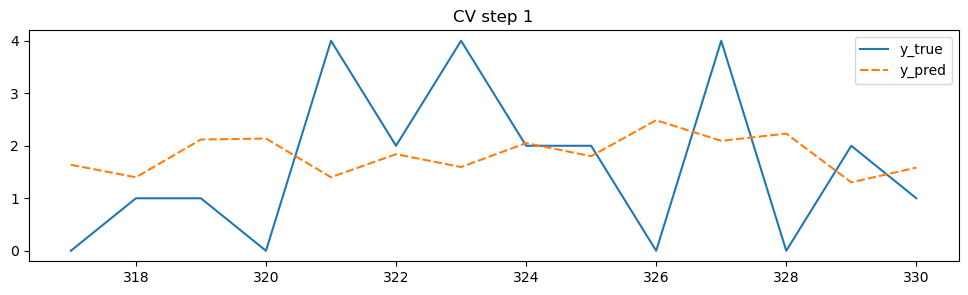

LGBM CV step 1 WAPE: 0.384285528294908


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 54.9856
[200]	valid_0's l2: 54.4236
[300]	valid_0's l2: 54.2371
[400]	valid_0's l2: 54.9643


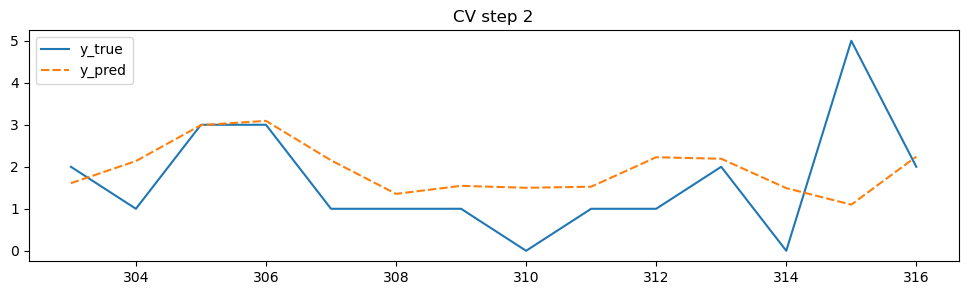

LGBM CV step 2 WAPE: 0.3569939171503536


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 104.36
[200]	valid_0's l2: 106.815


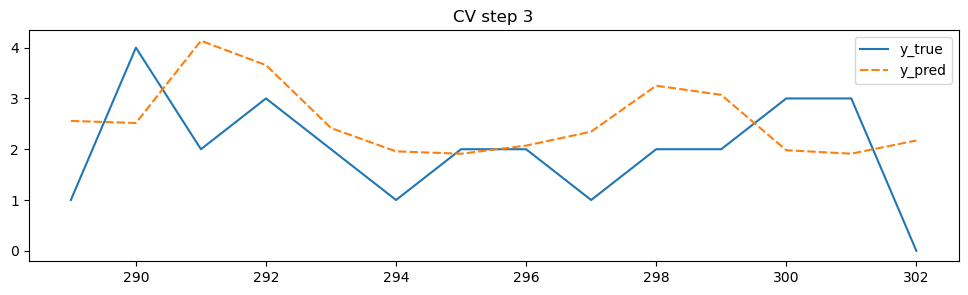

LGBM CV step 3 WAPE: 0.37638250110963556


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 92.6984
[200]	valid_0's l2: 93.3132


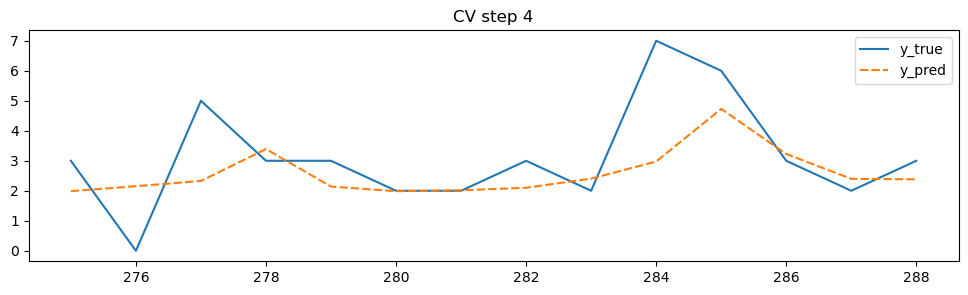

LGBM CV step 4 WAPE: 0.38349008213236213


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 180.995
[200]	valid_0's l2: 188.45


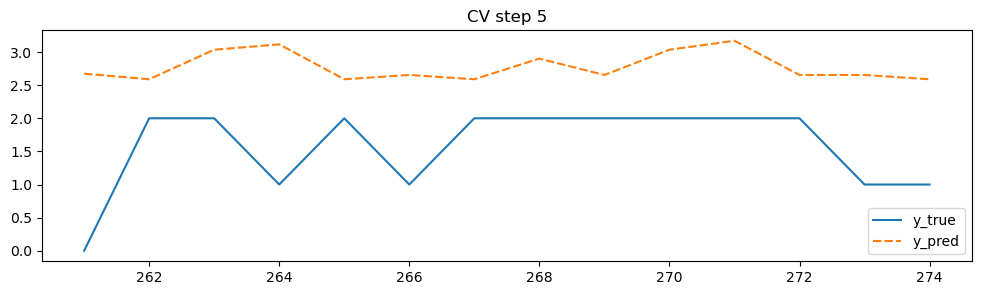

LGBM CV step 5 WAPE: 0.4283767999691861


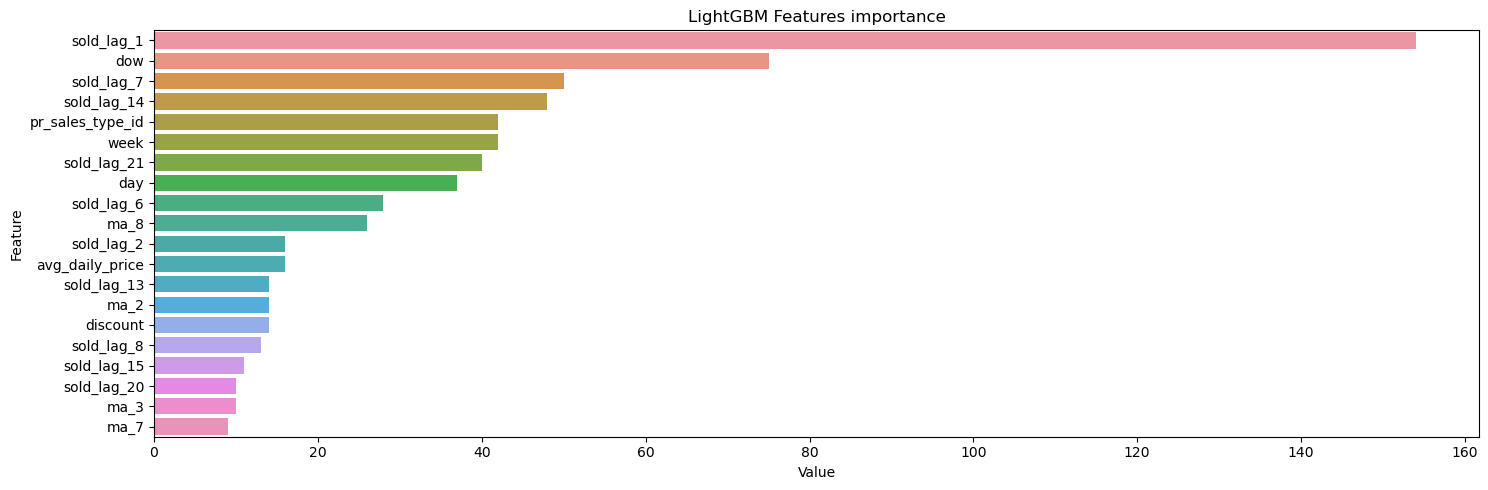

In [121]:
lgbm_wapes = lgbm_cross_val(df=with_ma, cat_features=['store_item', 
                                                          'pr_sales_type_id', 
                                                          'dow',  
                                                          'season'], 
                                            cols_to_drop=['date', 'sold', 'pr_sku_id', 'st_id'])

In [122]:
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.3859057657312891


Итерация 1

* Фичи: товар-магазин, 21 лаг
* ВЭЙП: 0.31946023074607927
* Важное: Лаги 1, 6, 7, 21, 14, 13, товар-магазин

Итерация 2

* Фичи: товар-магазин, 21 лаг, флаг промо
* ВЭЙП: 0.31190542656037545
* Важное: Лаги 1, 7, товар-магазин, лаги 6, 21, промо, 14, 13
* Вывод: с флажком промо конечно лучше

Итерация 3

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5)
* ВЭЙП: 0.29543868373613635
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, неделя, промо, лаги 14, 6, 21, день месяца, лаги 13, 2, 4
* Вывод: месяц и сезон не важны. День недели, номер недели, день месяца - хорошие признаки

Итерация 4

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина
* ВЭЙП: 0.2983241429592106
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, промо, неделя, лаги 6, 14, 21, день месяца, лаги 13, 2, 4
* Вывод: эта фича не улучшила метрику и не вошла в топ. Я оставлю айдишники, чтобы по ним приджойнить типы и категории

Итерация 5

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина, вся инфа о магазине
* ВЭЙП: 0.29772025048047446
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, день месяца, промо, неделя, лаги 21, 14, 6, 13, 5, 15
* Вывод: вообще ничего полезного в инфо о магазине. Уберу их из датасета

Итерация 6

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина, вся инфа о товаре
* ВЭЙП: 0.2972128043054486
* Важное: Лаг 1, день недели, товар-магазин, промо, лаг 7, неделя, лаги 6, 14, 21, день месяца, лаги 2, 13, 15
* Вывод: категории и подкатегории не важны. можно вернуться на этап 3, когда добавили календарные фичи

Итерация 7

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена
* ВЭЙП: 0.29813939400486966
* Важное: Лаг 1, товар-магазин, лаг 2, средняя цена, лаги 7, 3, 6, неделя, лаг 15, день месяца, лаги 5, 4, 16, 14
* Вывод: средняя цена - важный признак. Почему тогда снизилась метрика??? модель потеряла недельную цикличность: день недели ушел из списка, лаги 7, 14, 21 снизились по важности, в топ вышли лаги последних дней. Еще и промо потерялось. Его можно убрать только на следующей итерации, когда добавим размер скидки

Итерация 8

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена. Минус лаги 2 и 3
* ВЭЙП: 0.29239544645625787
* Важное: Лаг 1, товар-магазин, средняя цена, лаги 7, 4, неделя, лаг 6, день месяца, лаги 8, 21, 14, 15, день недели
* Вывод: я сейчас верну эти лаги, просто хотелось немного подсказать модели. Пока это лучшая метрика. День недели вернулся, правильная сезонность восстановлена

Итерация 9

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки
* ВЭЙП: 0.2903170138654366
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, промо, средняя цена, неделя, лаги 14, 21, 6, 2, день месяца 
* Вывод: мне такое распределение больше всего нравится. день неджели поднялся в топ3, флажок промо вернулся. Но она не видит мой процент скидки

Итерация 10

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки
* ВЭЙП: 0.32029594697514907
* Важное: Лаг 1, товар-магазин, день недели, лаги 2, 7, неделя, средняя цена, день месяца, лаги 14, 21, 8, 6, 13  
* Вывод: увеличила набор до топ100. Нельзя масштабировать без потери качества. Вернусь к 50. Хотя это не значит, что так делать не надо: может если мы построим разные модели для топ50 и остальных, после объединения качество упадет сильнее

Итерация 11

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки, канун праздника
* ВЭЙП: 0.2903170138654366
* Важное: Лаг 1, товар-магазин, день недели, лаги 2, 7, неделя, средняя цена, день месяца, лаги 14, 21, 8, 6, 13  
* Вывод: нет влияния на метрику. по-моему праздники просто не попадают в нашу валидацию. сделала больше фолдов кросс-валидации (чтобы выборка дотянулась до майских). тогда без новой фичи метрика чуть лучше, чем с ней

Итерация 12

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки, скользящие средние по продажам
* ВЭЙП: 0.29396104069940276
* Важное: Лаг 1, товар-магазин, средняя цена, МА2, лаг 2, неделя, лаги 14, 7, день месяца, лаг 16, МА3, день недели, лаги 20, 6, скидка  
* Вывод: нет влияния на метрику. по-моему праздники просто не попадают в нашу валидацию. сделала больше фолдов кросс-валидации (чтобы выборка дотянулась до майских). тогда без новой фичи метрика чуть лучше, чем с ней



In [123]:
def objective(trial, data=with_ma, cols_to_drop=['sold', 'date', 'pr_sku_id', 'st_id'], cat_features=['store_item', 'pr_sales_type_id', 'dow', 'season']):
    
    end_train = data['date'].max() - pd.Timedelta(days=14)
    train = data[data['date'] <= end_train]
    valid = data[data['date'] > end_train]

    train_x = train.drop(cols_to_drop, axis=1)
    train_y = train['sold']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['sold']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-09-29 16:58:42,471] A new study created in memory with name: no-name-cc9ded7a-8d16-4462-83d6-68a9e0c20796
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced b

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.2


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.05373
[1000]	valid_0's l1: 4.041


[I 2023-09-29 16:58:54,940] Trial 0 finished with value: 0.3756271581872545 and parameters: {'reg_alpha': 4.65333290434587, 'reg_lambda': 1.9890735581874817, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 440, 'min_child_samples': 179, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.3756271581872545.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logun

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 16:59:03,568] Trial 1 finished with value: 0.37145494994242384 and parameters: {'reg_alpha': 0.002540480674929846, 'reg_lambda': 6.3516998636294835, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 935, 'min_child_samples': 154, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.37145494994242384.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.01475
[1000]	valid_0's l1: 3.9842
[1500]	valid_0's l1: 3.97802
[2000]	valid_0's l1: 3.97374


[I 2023-09-29 17:00:15,541] Trial 2 finished with value: 0.36941276580442506 and parameters: {'reg_alpha': 3.3133555294265182, 'reg_lambda': 0.0018320651646663122, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 494, 'min_child_samples': 3, 'feature_fraction': 0.4}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 17:00:47,108] Trial 3 finished with value: 0.370870184048695 and parameters: {'reg_alpha': 0.5882013363344262, 'reg_lambda': 0.15055437275017736, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 692, 'min_child_samples': 17, 'feature_fraction': 0.4}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.03552


[I 2023-09-29 17:01:52,207] Trial 4 finished with value: 0.37110246117869056 and parameters: {'reg_alpha': 6.230503010762183, 'reg_lambda': 0.13335865285127987, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 448, 'min_child_samples': 249, 'feature_fraction': 0.7}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.2


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.10509
[1000]	valid_0's l1: 4.05765


[I 2023-09-29 17:02:17,712] Trial 5 finished with value: 0.3770878744461321 and parameters: {'reg_alpha': 0.008264257453735147, 'reg_lambda': 0.12990068862681203, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 65, 'min_child_samples': 219, 'feature_fraction': 0.2}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 17:02:32,745] Trial 6 finished with value: 0.37235282211109144 and parameters: {'reg_alpha': 0.0062875851786741745, 'reg_lambda': 0.12027619623014227, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 267, 'min_child_samples': 222, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.05393
[1000]	valid_0's l1: 4.00811


[I 2023-09-29 17:03:14,750] Trial 7 finished with value: 0.3727176367573116 and parameters: {'reg_alpha': 0.8276024362016298, 'reg_lambda': 0.17099514798112708, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 319, 'min_child_samples': 5, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_log

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 17:03:29,565] Trial 8 finished with value: 0.37058401281502396 and parameters: {'reg_alpha': 0.12501803902835032, 'reg_lambda': 0.07340971392833118, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 454, 'min_child_samples': 71, 'feature_fraction': 0.5}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 17:04:13,711] Trial 9 finished with value: 0.3721404841486742 and parameters: {'reg_alpha': 0.01835150174225656, 'reg_lambda': 0.008934341265675137, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 857, 'min_child_samples': 209, 'feature_fraction': 0.9}. Best is trial 2 with value: 0.36941276580442506.


Number of finished trials: 10
Best trial: {'reg_alpha': 3.3133555294265182, 'reg_lambda': 0.0018320651646663122, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 494, 'min_child_samples': 3, 'feature_fraction': 0.4}


In [124]:
study.optimize(objective, n_trials=10, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarn

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.98643


[I 2023-09-29 17:04:45,641] Trial 10 finished with value: 0.3705056154568687 and parameters: {'reg_alpha': 9.7540913180648, 'reg_lambda': 0.001170793938553175, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 715, 'min_child_samples': 89, 'feature_fraction': 0.6000000000000001}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': tr

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.9839


[I 2023-09-29 17:05:09,036] Trial 11 finished with value: 0.37027313975395026 and parameters: {'reg_alpha': 9.741443859909666, 'reg_lambda': 0.0012456885996145423, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 681, 'min_child_samples': 83, 'feature_fraction': 0.6000000000000001}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda'

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.98266


[I 2023-09-29 17:05:31,846] Trial 12 finished with value: 0.37017206232153227 and parameters: {'reg_alpha': 1.773170871749567, 'reg_lambda': 0.0010331131525172126, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 615, 'min_child_samples': 88, 'feature_fraction': 0.6000000000000001}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda'

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.9955


[I 2023-09-29 17:05:50,281] Trial 13 finished with value: 0.37143270551859303 and parameters: {'reg_alpha': 1.2620767059532771, 'reg_lambda': 0.0057659661527139465, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 587, 'min_child_samples': 50, 'feature_fraction': 0.4}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.00424


[I 2023-09-29 17:06:13,079] Trial 14 finished with value: 0.37211315656808236 and parameters: {'reg_alpha': 0.2028209012301825, 'reg_lambda': 0.004554610766939688, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 231, 'min_child_samples': 125, 'feature_fraction': 0.7}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugges

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.01852


[I 2023-09-29 17:06:45,427] Trial 15 finished with value: 0.3728525260642656 and parameters: {'reg_alpha': 2.174639539128314, 'reg_lambda': 0.0010660564316517583, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 817, 'min_child_samples': 296, 'feature_fraction': 0.4}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.00982


[I 2023-09-29 17:07:02,816] Trial 16 finished with value: 0.3724919611677012 and parameters: {'reg_alpha': 0.41502187759467263, 'reg_lambda': 0.013973988245823781, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 550, 'min_child_samples': 38, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda'

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-09-29 17:07:15,529] Trial 17 finished with value: 0.37535739199089824 and parameters: {'reg_alpha': 2.2340880680683104, 'reg_lambda': 0.0030992166987722203, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 99, 'min_child_samples': 117, 'feature_fraction': 0.7}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.99795


[I 2023-09-29 17:07:49,120] Trial 18 finished with value: 0.3704512977730157 and parameters: {'reg_alpha': 0.059449540792182363, 'reg_lambda': 0.023596672462162557, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 356, 'min_child_samples': 45, 'feature_fraction': 0.5}. Best is trial 2 with value: 0.36941276580442506.
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_8136\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugge

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.95722


[I 2023-09-29 17:08:28,361] Trial 19 finished with value: 0.3677937733328069 and parameters: {'reg_alpha': 2.902983991404626, 'reg_lambda': 0.0031181995004849255, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 618, 'min_child_samples': 99, 'feature_fraction': 0.6000000000000001}. Best is trial 19 with value: 0.3677937733328069.


LGBM WAPE: 0.3677937733328069


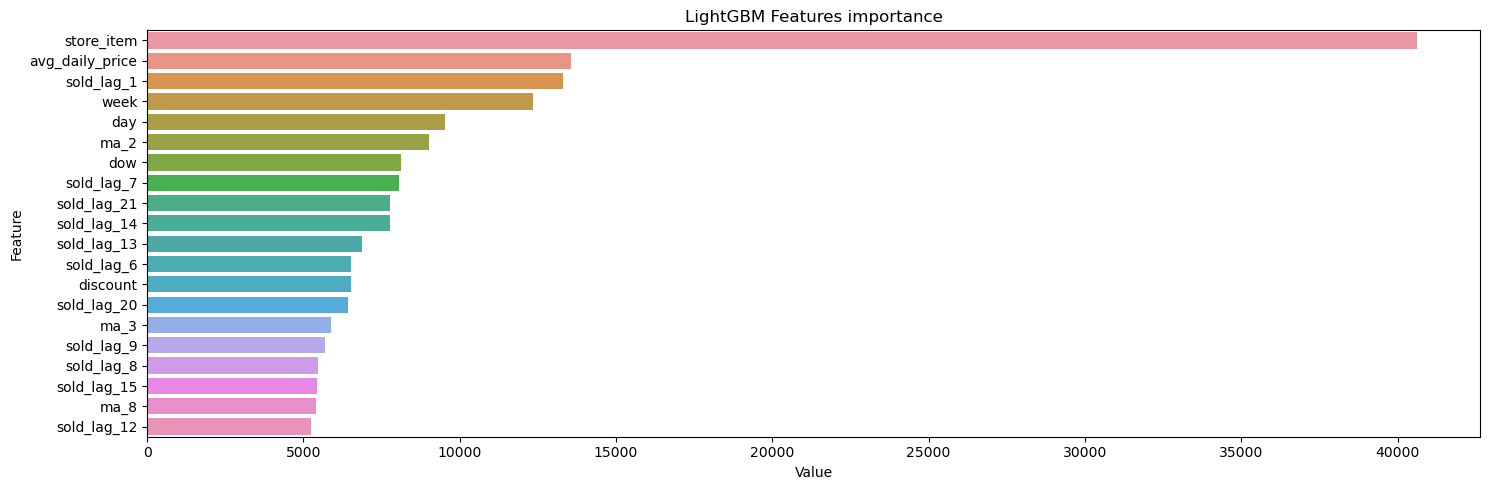

In [125]:
data=with_ma
cols_to_drop=['sold', 'date', 'pr_sku_id', 'st_id']
cat_features=['store_item', 'pr_sales_type_id', 'dow', 'season']

end_train = data['date'].max() - pd.Timedelta(days=14)
train = data[data['date'] <= end_train]
valid = data[data['date'] > end_train]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['sold']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['sold']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

LGBM WAPE: 0.28035633797758186
После оптимизации оптуной

Feature importance
1. store_item
2. lag 1
3. avg daily price
4. dow
5. ma2
6. lag 7
7. lag 21
8. day of month
9. week number 
10. lag 6
11. lag 14
12. discount %
13. lag 13
14. lag 20
15. lag 9
16. ma3
17. lag 2
18. lag 16
19. lag 11
20. lag 10

In [116]:
#rewrite forecast algorythm so that the model could handle test with only store/sku/date
#get lines from submission form
sample_sub = pd.read_csv('sales_submission.csv')
sample_sub['date'] = pd.to_datetime(sample_sub['date']).dt.normalize()
sample_sub['store_item'] = sample_sub['st_id'].str.cat(sample_sub['pr_sku_id'], sep='-')
flagman_sub = sample_sub[sample_sub['store_item'].isin(flagman['store_item'])]
flagman_sub = flagman_sub.drop('store_item', axis=1)
flagman_sub[flagman_sub['date'] == flagman_sub['date'].min()].shape

(780, 4)

In [117]:
def preprocess_test(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags
    pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'sold_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'sold']
        
    #no promo by default
    pred_with_history['pr_sales_type_id'] = 0
    pred_with_history['discount'] = 0    
    
    #add features of day-of-week, day-of-month, week, month, season
    pred_with_history['dow'] = pred_with_history['date'].dt.dayofweek
    pred_with_history['day'] = pred_with_history['date'].dt.day
    pred_with_history['week'] = pred_with_history['date'].dt.isocalendar().week.astype('int32')
    pred_with_history['month'] = pred_with_history['date'].dt.month
    pred_with_history['season'] = pred_with_history['date'].dt.quarter    
    
    #take daily price from yesterday. replace with ARIMA counted later
    pred_with_history['avg_daily_price'] = pred_with_history['avg_daily_price'].shift(1, axis=0)    
    
    #add moving averages
    for n in range(2, 22):
        pred_with_history['ma_' + str(n)] = pred_with_history[['sold_lag_' + str(x) for x in range(1, n+1)]].sum(axis=1) / n

    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [118]:
#this is what we'll get as input
first_pred = flagman_sub[flagman_sub['date'] == flagman_sub['date'].min()].sample(1)
first_pred

,st_id,pr_sku_id,date,target
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-19,0


In [119]:
def make_forecast_for_sample_row(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        lower_row['store_item'] = lower_row['st_id'].str.cat(lower_row['pr_sku_id'], sep='-')

        #if first line take lags from the last line of train. otherwise from previous predicted line
        if i == 0:
            last_train_date = with_ma['date'].max()
            upper_row = with_ma[(with_ma['store_item'] == lower_row['store_item'].item()) & (with_ma['date'] == last_train_date)]
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])
        last_preprocessed = preprocess_test(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['sold', 'target', 'date', 'pr_sku_id', 'st_id'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

make_forecast_for_sample_row(first_pred)

,st_id,pr_sku_id,date,target
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-19,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-20,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-21,5
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-22,5
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-23,4
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-24,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-25,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-26,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-27,3
25351,16a5cdae362b8d27a1d8f8c7b78b4330,b75c7cbf7accdaea8a1a14781bb29870,2023-07-28,5


,sold,target
date,,
2023-07-05,1.0,NaN
2023-07-06,2.0,NaN
2023-07-07,5.0,NaN
2023-07-08,4.0,NaN
2023-07-09,3.0,NaN
2023-07-10,3.0,NaN
2023-07-11,6.0,NaN
2023-07-12,3.0,NaN
2023-07-13,5.0,NaN


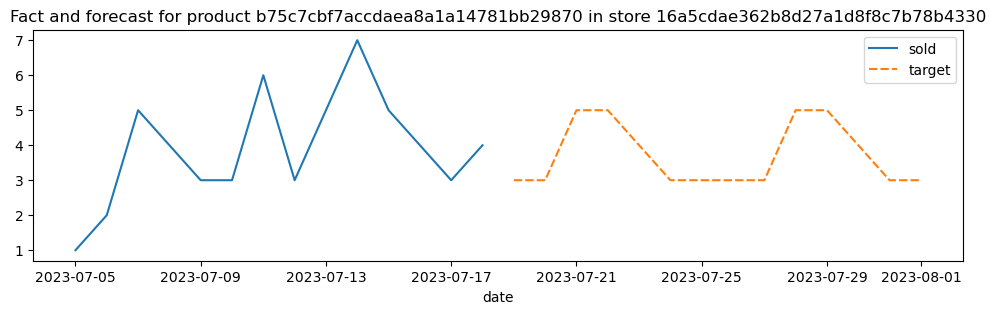

In [120]:
# same as previous function but plots fact-forecast
def forecast_and_plot(row, h=14):

    first_pred['store_item'] = first_pred['st_id'].str.cat(first_pred['pr_sku_id'], sep='-')
    last_train_date = with_ma['date'].max()
    
    fact = pd.DataFrame()    
    for i in range(14):
        line = with_ma[(with_ma['store_item'] == first_pred['store_item'].item()) & (with_ma['date'] == last_train_date - pd.Timedelta(days=(13-i)))]
        fact = pd.concat([fact, line[['st_id', 'pr_sku_id', 'date', 'sold']]])

    forecast = make_forecast_for_sample_row(first_pred)

    total = pd.concat([fact, forecast])[['date', 'sold', 'target']].set_index('date')
    display(total)

    fig, ax = plt.subplots(figsize=(12, 3))
    g = sns.lineplot(data=total)
    plt.title(f"Fact and forecast for product {first_pred['pr_sku_id'].item()} in store {first_pred['st_id'].item()}")
    plt.show()

    

forecast_and_plot(first_pred)
